# Installing and importing packages

In [1]:
!pip install tf-nightly-gpu
!pip install "tensorflow_hub==0.4.0"
!pip install -U tensorflow_datasets

     |████████████████████████████████| 397.1MB 51kB/s 
     |████████████████████████████████| 3.2MB 40.0MB/s 
     |████████████████████████████████| 61kB 29.7MB/s 
     |████████████████████████████████| 501kB 50.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/51/3e/a3/b351fae0cbf15373c2136a54a70f43fea5fe91d8168a5faaa4
Successfully built opt-einsum
     |████████████████████████████████| 81kB 3.0MB/s 
  Found existing installation: tensorflow-hub 0.5.0
    Uninstalling tensorflow-hub-0.5.0:
      Successfully uninstalled tensorflow-hub-0.5.0
     |████████████████████████████████| 686kB 2.8MB/s 


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
tf.enable_eager_execution()

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [0]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [4]:
splits = tfds.Split.TRAIN.subsplit([70, 30])
(training_set, validation_set), dataset_info = tfds.load('tf_flowers', with_info=True, as_supervised=True, split=splits)

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/1.0.0. Subsequent calls will reuse this data.


In [9]:
num_classes = dataset_info.features['label'].num_classes

num_training_examples = 0
num_validation_examples = 0

for example in training_set:
  num_training_examples += 1
  
for example in validation_set:
  num_validation_examples += 1

print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {}\n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 2590
Total Number of Validation Images: 1080



In [10]:
for i, example in enumerate(training_set.take(5)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (240, 179, 3) label: 4
Image 2 shape: (292, 500, 3) label: 1
Image 3 shape: (333, 500, 3) label: 1
Image 4 shape: (240, 240, 3) label: 4
Image 5 shape: (324, 500, 3) label: 1


# Reformating Image

In [0]:
IMAGE_RES = 224

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [12]:
for i, example in enumerate(train_batches.take(5)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (32, 224, 224, 3) label: [4 0 0 2 4 2 4 0 1 3 3 3 0 4 0 0 2 2 2 0 4 2 4 3 2 1 2 0 1 2 1 2]
Image 2 shape: (32, 224, 224, 3) label: [0 3 0 3 0 3 4 1 1 4 0 3 2 3 0 3 2 2 2 2 1 4 3 2 3 1 2 3 2 3 3 3]
Image 3 shape: (32, 224, 224, 3) label: [3 4 4 4 0 2 0 4 3 4 4 4 0 0 3 4 4 1 1 4 0 3 2 4 0 3 0 3 3 4 2 2]
Image 4 shape: (32, 224, 224, 3) label: [2 2 3 3 1 2 2 2 4 1 0 3 4 3 2 2 1 1 1 0 3 1 4 1 0 3 2 0 1 0 3 2]
Image 5 shape: (32, 224, 224, 3) label: [3 3 0 0 2 4 0 3 3 3 2 2 4 0 1 0 0 0 2 4 0 2 2 4 3 1 1 3 1 0 3 1]


# Transfer Learning from TF Hub

In [0]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL, input_shape=(RES, RES, 3))
feature_extractor.trainable = False

In [0]:
model = tf.keras.Sequential([
    feature_extractor,
    layers.Dense(num_classes, activation='softmax')
])

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
             )

In [16]:
EPOCHS = 6
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 21s 263ms/step - loss: 0.9502 - acc: 0.6710 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/6
81/81 [==============================] - 10s 125ms/step - loss: 0.5223 - acc: 0.8471 - val_loss: 0.4878 - val_acc: 0.8500
Epoch 3/6
81/81 [==============================] - 10s 124ms/step - loss: 0.4343 - acc: 0.8764 - val_loss: 0.4672 - val_acc: 0.8657
Epoch 4/6
81/81 [==============================] - 10s 125ms/step - loss: 0.3813 - acc: 0.8996 - val_loss: 0.4611 - val_acc: 0.8667
Epoch 5/6
81/81 [==============================] - 10s 123ms/step - loss: 0.3428 - acc: 0.9174 - val_loss: 0.4596 - val_acc: 0.8694
Epoch 6/6
81/81 [==============================] - 10s 126ms/step - loss: 0.3126 - acc: 0.9290 - val_loss: 0.4601 - val_acc: 0.8630


# Analysis

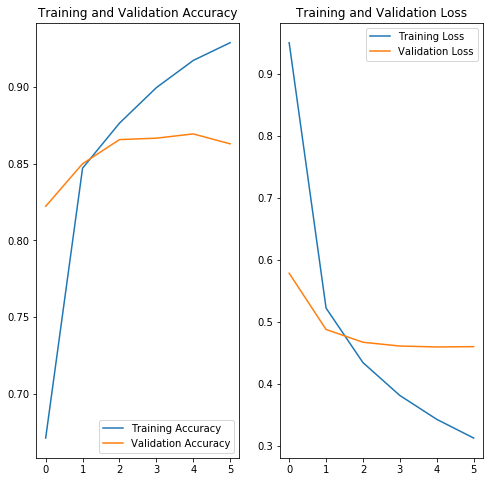

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
class_names = np.array(dataset_info.features['label'].names)

print(class_names)

image_batch, label_batch = next(iter(train_batches))


image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']
['roses' 'dandelion' 'dandelion' 'tulips' 'roses' 'tulips' 'tulips'
 'dandelion' 'daisy' 'sunflowers' 'sunflowers' 'sunflowers' 'dandelion'
 'roses' 'dandelion' 'dandelion' 'tulips' 'tulips' 'tulips' 'dandelion'
 'roses' 'tulips' 'roses' 'sunflowers' 'tulips' 'daisy' 'tulips'
 'dandelion' 'dandelion' 'tulips' 'daisy' 'tulips']


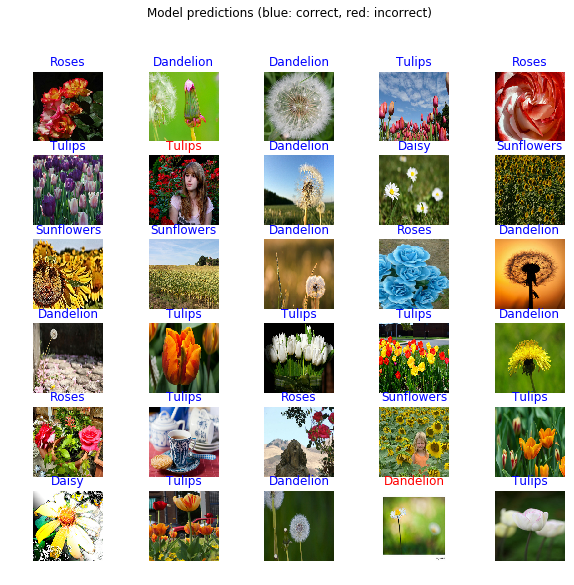

In [20]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")